# This is exact same as `Final Caption Keras-Bidrectional-GRU-based sentiment analysis of OASIS dataset captions` notebook

Only without class weights

In [1]:
import os, sys, io,re, string, pathlib, random
from collections import Counter, OrderedDict

import hecutils.data_utils as dt
import hecutils.scoring_utils as sc
import hecutils.plotting_utils as pt
import hecutils.caption_utils as caput
import hecutils.image_utils as imut


import tensorflow as tf
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.layers import Dense, Conv1D, MaxPooling1D, GRU, Bidirectional, LSTM
from keras.layers.core import Dropout, Flatten, Masking, ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from keras import regularizers
from keras.preprocessing import text
from keras.layers.embeddings import Embedding

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import StratifiedKFold, train_test_split

import numpy as np
import pandas as pd


from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

import matplotlib.pyplot as plt
import time

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

None


Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

num_cores = 8
GPU=True
CPU = not GPU

if GPU:
    num_GPU = 1
    num_CPU = 8
if CPU:
    num_CPU = 8
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

In [3]:
# fix random seed for reproducibility
seed = 7

oasis_csv_path = "dataset/metadata/OASIS.csv"
captions_root = "/home/elkhand/git-repos/human-emotions-classifier/dataset/metadata"
captions_root_path = pathlib.Path(captions_root)
human_output_caption_to_label_csv_path = captions_root_path/'humanCaptionWithLabeldf2.csv'
human_caption_csv_path = captions_root_path/'captions.csv'
#fasttext_embedding_path = 'embedding/wiki-news-300d-1M.vec'
fasttext_embedding_path = '/home/elkhand/datasets/glove-vectors/glove.twitter.27B.200d.txt'
model_results_root_dir = "model2/"
inputDataset_csv_path = captions_root_path/"inputDataset2.csv"
testDataset_csv_path = captions_root_path/"testDataset2.csv"

neutralLow = 3.0 
neutralHigh = 5.0

auto_output_caption_to_label_csv_path = captions_root_path/'autoCaptionWithLabeldf2.csv'
auto_caption_csv_path = captions_root_path/'auto_generated_captions.csv'


dataset_path = human_output_caption_to_label_csv_path
# dataset_path = auto_output_caption_to_label_csv_path

kfold_splits = 10 
test_size = 0.1

embedding_dimension = 200 # 300
batch_size = 16 
nb_epochs = 100
dropout = 0.3 
recurrent_dropout=  0.5 
patience = 10
verbose = 1

useF1Score = True # True

## Original: separating data into test and input

In [28]:
# dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)
# dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

# df = pd.read_csv(dataset_path, header=0, sep="|")
# df["caption"] = df["caption"].apply(lambda x: " ".join(caput.get_words_withoutstopwords(x.lower().split())))
# df["label"] = df["label"].apply(lambda x: caput.change_label_str_to_int(x))



# input_x, test_x, input_y,  test_y = train_test_split(df["caption"],
#                                                      df["label"],
#                                                      test_size=test_size,
#                                                      random_state=seed,
#                                                      stratify=df["label"])

# inputDataset = pd.concat([input_x, input_y], axis=1)
# testDataset = pd.concat([test_x, test_y], axis=1)

# inputDataset = inputDataset.dropna()
# testDataset = testDataset.dropna()
# inputDataset = inputDataset.reset_index()
# testDataset = testDataset.reset_index()


# inputDataset.to_csv(inputDataset_csv_path, index=False, sep="|")
# testDataset.to_csv(testDataset_csv_path, index=False, sep="|")

# print("df.head()\n", df.head())
# print("\n")
# print("df.tail()\n", df.tail())
# print("\n")
# print("inputDataset.head()\n", inputDataset.head())
# print("testDataset.head()\n", testDataset.head())
# print("\n")
# print("Label distribution in inputDataset", inputDataset.groupby('label').label.count())
# print("Label distribution in testDataset", testDataset.groupby('label').label.count())

## Common way of separating data into input and test

### Divide data into train/val/test datasets

Read dataframe to have:

<imageName, caption, label>

1. Read into df <imageId, label>
2. Then separate data into input and test datasets

In [9]:
dt.create_caption_to_label(oasis_csv_path,human_caption_csv_path, human_output_caption_to_label_csv_path,neutralLow, neutralHigh)
dt.create_caption_to_label(oasis_csv_path,auto_caption_csv_path, auto_output_caption_to_label_csv_path,neutralLow, neutralHigh)

dfImageIdCaptionLabel = pd.read_csv(dataset_path, header=0, sep="|")
dfImageIdCaptionLabel.columns = ["id","caption", "label"]
dfImageIdCaptionLabel["caption"] = dfImageIdCaptionLabel["caption"].apply(lambda x: " ".join(caput.get_words_withoutstopwords(x.lower().split())))
#dfImageIdCaptionLabel["label"] = dfImageIdCaptionLabel["label"].apply(lambda x: caput.change_label_str_to_int(x))


dfImageIdImageName = dt.get_image_id_to_image_title_as_df(oasis_csv_path)
dfImageIdImageName.columns = ['id', 'image_name']
dfImageIdImageName['image_name'] = dfImageIdImageName['image_name'].apply(lambda x: x + ".jpg") 
printCnt = 5
# has [id, caption, label]
df = pd.merge(dfImageIdCaptionLabel, dfImageIdImageName, on="id")
df["label"] = df["label"].apply(lambda x: caput.change_label_str_to_int(x))
#print(df.head(printCnt))



input_x, test_x, input_y,  test_y = train_test_split(df["id"],
                                                     df["label"],
                                                     test_size=test_size,
                                                     random_state=seed,
                                                     stratify=df["label"])

inputDataset = pd.concat([input_x, input_y], axis=1)
testDataset = pd.concat([test_x, test_y], axis=1)



# print("inputDataset\n", inputDataset.head(10))
# print("testDataset\n", testDataset.head(10))

print("\n")
print("Label distribution in inputDataset", inputDataset.groupby('label').label.count())
print("Label distribution in testDataset", testDataset.groupby('label').label.count())


inputDataset = df.loc[df['id'].isin(inputDataset.id)]
testDataset = df.loc[df['id'].isin(testDataset.id)]


inputDataset = inputDataset.dropna()
testDataset = testDataset.dropna()
inputDataset = inputDataset.reset_index()
testDataset = testDataset.reset_index()

# print("inputData\n", inputData.head())
# print("testData\n", testData.head())

inputIds = set(inputDataset['id'].values)
testIds = set(testDataset['id'].values)

print("Input data size", len(inputIds))
print("Test data size", len(testIds))

for inputId in inputIds:
    if inputId in testIds:
        raise inputId + " inputId exists both in test and input dataset"
        
for testId in testIds:
    if testId in inputIds:
        raise testId + " testId exists both in test and input dataset"        

#inputDataset.head()
print("head:\n")
print(testDataset.head(10))
print("tail\n")
print(testDataset.tail(10))



Label distribution in inputDataset label
-1    147
 0    378
 1    285
Name: label, dtype: int64
Label distribution in testDataset label
-1    16
 0    42
 1    32
Name: label, dtype: int64
Input data size 810
Test data size 90
head:

   index    id                                            caption  label  \
0      1   I10  bar several bottles wine partially-filled wine...      0   
1      5  I103  smiling woman wearing orange top blue shorts, ...      1   
2      8  I106  three men two women dressed medieval costumes ...      1   
3     13  I110  three boys playing refugee camp tents behind t...      0   
4     14  I111  person wearing hat coat sunburned faced lookin...      0   
5     19  I116  blue car hood smashed side road people looking...     -1   
6     60  I153       group male workers, mostly children factory.      0   
7     79  I170  cup coffee heart shape made milk foam, saucer ...      1   
8     86  I177  leafless tree, covered snow. ground tree also ...      1   
9  

## Load Embeddings

In [15]:
def load_embedding(path):
    word2vec = {}
    with io.open(path, encoding="utf8") as f:
        for line in f:
            entries = line.rstrip().split(" ")
            word, entries = entries[0], entries[1:]
            word2vec[word] = np.array(entries).astype(np.float) # Convert String type to float
    print('embedding size : %d' % len(word2vec))
    print('embedding dimension : %s' % (word2vec['apple'].shape,))
    return word2vec
    
wordToVec = {}
wordToVec = load_embedding(fasttext_embedding_path)



embedding size : 1193514
embedding dimension : (200,)


In [17]:
def build_model(max_seq_len, num_of_classes, config): 
    # Cross-validation results: 0.61% (+/- 0.13%)
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(None, config['embedding_dimension'])))
    model.add(LSTM(max_seq_len, return_sequences=True, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'])) 
    model.add(LSTM(max_seq_len, dropout=config['dropout'], recurrent_dropout=config['recurrent_dropout'])) 
    model.add(Dense(num_of_classes, activation='softmax'))
    
    if config['useF1Score']:
        metrics = ['accuracy', sc.f1, sc.recall, sc.precision]
    else:
        metrics = ['accuracy']
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=metrics)
    #print(model.summary())
    return model




def evalaute_on_test_data(model, testDataset, inputDataset, wordToVec, config):
    print("filenames: ", testDataset['image_name'].values)
    max_seq_len = int(testDataset['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    num_of_classes, class_to_index, index_to_class = caput.get_label_map_from_train_set(inputDataset, wordToVec, max_seq_len, config)
    X_test, y_test_index, _, _, _  = caput.load_dataset_StratifiedKFold(testDataset,wordToVec,max_seq_len,class_to_index, index_to_class, config)
    y_test = caput.convert_index_to_one_hot(y_test_index, num_of_classes) 
    print(model.summary())
    results = model.evaluate(X_test, y_test, verbose=1) # batch_size=1,
    print(model.metrics_names, results)
        
    predictions = model.predict(X_test, verbose=1)    
    print("predictions:\n",predictions)
    print("\n")
    print("class_to_index:", class_to_index)
    print("index_to_class:", index_to_class)
    predictionClasses = imut.conver_predictions_to_classes(predictions, class_to_index)
    y_test_classes = [index_to_class[k] for k in y_test_index]
    y_true = y_test_classes
    print("y_true:\n", y_true)
    print("\n")
    y_pred = predictionClasses
    print("y_pred:\n", y_pred)
    
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print("cnf_matrix", cnf_matrix)
    titleOfConfusionMatrix = "Confusion Matrix based on GRU based Seq2seq model on captions"
    pt.plot_confusion_matrix_from_labels(y_true, y_pred, titleOfConfusionMatrix)
    misLabeledCount = 0
    for index, row in testDataset.iterrows():
        caption = row['caption']
        label = row['label']
        if label != y_true[index]:
            print(caption)
            raise "Unexpected result, truth labels should have matched, seems the order is messed up"
        if label != y_pred[index]:
            print(caption,"TL", label,"PL", y_pred[index])
            misLabeledCount += 1 
    print("\n")
    print("Mislabeled count: ", misLabeledCount)


def train_StratifiedKFold(inputDataset, testDataset, wordToVec, config):
    """StratifiedKFold cross-validation"""
    # Shuffle dataset
    df = shuffle(inputDataset)
    X = df["caption"]
    y = df["label"]
    print("Label distribution: ",df.groupby('label').label.count())
    max_seq_len = int(df['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    
    # Instantiate the cross validator
    skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)
    cv_accuracies = []
    cv_f1s = []
    
    best_model = None
    best_model_best_acc = -1
    
    # Loop through the indices the split() method returns
    for index, (train_indices, val_indices) in enumerate(skf.split(X, y)):
        print("train_indices[:5]", train_indices[:5],"train_indices[-5:]",train_indices[-5:])
        print("val_indices[:5]", val_indices[:5],"val_indices[-5:]",val_indices[-5:])
        print()
        
        
        start = time.time()        
        class_to_index = {}
        index_to_class = {}
        
        X_train_caption, X_val_caption = X[train_indices], X[val_indices]
        y_train_index, y_val_index = y[train_indices], y[val_indices]
        
        dfTrain = pd.concat([X_train_caption, y_train_index], axis=1)
        dfTrain.columns = ['caption', 'label']
        
        print(dfTrain.head())
        
        X_train, y_train_index, num_of_classes, class_to_index, index_to_class = \
            caput.load_dataset_StratifiedKFold(
                            dfTrain,
                            wordToVec, 
                            max_seq_len, 
                            class_to_index, 
                            index_to_class,
                            config)
        y_train = caput.convert_index_to_one_hot(y_train_index, num_of_classes) 
        
#         y_ints = [y.argmax() for y in y_train]
#         class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_ints),
#                                                  y_ints)
#         print("class_weights", class_weights)
        print("class_to_index", class_to_index)
        print("index_to_class", index_to_class)
        
        dfVal= pd.concat([X_val_caption, y_val_index], axis=1)
        dfVal.columns = ['caption', 'label']
        X_val, y_val_index, _, _, _ = caput.load_dataset_StratifiedKFold(
                            dfVal,
                            wordToVec,
                            max_seq_len, 
                            class_to_index, 
                            index_to_class,
                            config)
        y_val = caput.convert_index_to_one_hot(y_val_index, num_of_classes) 
        
        
        print("\nTRAIN size:", len(train_indices), "\t VAL size:", len(val_indices))
        print("Train label distribution: ",dfTrain.groupby('label').label.count())
        print("Val label distribution: ",dfVal.groupby('label').label.count())

        
        model = build_model(max_seq_len,num_of_classes, config)
        
        plot_model(model, to_file = model_results_root_dir + '/model.png', show_shapes=True, show_layer_names=True)#
        
        
        # Log to tensorboard
        tensorBoardCallback = TensorBoard(log_dir=model_results_root_dir + '/logs', write_graph=True)
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.5, 
                                  patience=2, 
                                  min_lr=1e-7,
                                  cooldown=1,
                                  verbose=1)
        
        history = {}
        filename = ""
        # checkpoint
        filepath= model_results_root_dir + "/weights.best.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
        
        callbacks_list = [checkpoint,  reduce_lr, early_stopping, tensorBoardCallback]  # 
        
        history = model.fit(x=X_train,
                      y=y_train, 
                      batch_size=config['batch_size'],
                      epochs=config['nb_epochs'], 
                      verbose=config['verbose'], 
                      validation_data = (X_val, y_val),
                      shuffle=True,
                      callbacks=callbacks_list)        # 
        val_acc_list = history.history['val_acc']
        best_val_acc =  max(val_acc_list)
        cv_accuracies.append(best_val_acc)
        print("best_val_acc: ", best_val_acc)
        
        if config['useF1Score']:
            val_f1_list = history.history['val_f1']
            best_f1 =  max(val_f1_list)
            print("best_f1: ", best_f1)
            cv_f1s.append(best_f1)
        
        filename = "caption" 
        filename = model_results_root_dir + caput.generate_model_name(filename, best_val_acc) + ".h5"
        os.rename(filepath, filename)
        
        pt.plot_model_accuracy(history,model_results_root_dir, config['useF1Score'])
        
        end = time.time()
        print("Time passed for training", (end-start))
        
        if best_val_acc > best_model_best_acc:
            best_model_best_acc = best_val_acc
            best_model = model
    
    print("=========================================")
    print("Cross-validation val accuracy results: " , cv_accuracies)
    print("Cross-validation val accuracy results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_accuracies), np.std(cv_accuracies)))
    
    print("\n","Cross-validation val f1 results: " , cv_f1s)
    print("Cross-validation val f1 results: %.2f%% (+/- %.2f%%)" % (np.mean(cv_f1s), np.std(cv_f1s)))
    
    best_model.save(model_results_root_dir + "/bestmodel-" + str(best_model_best_acc) + ".h5")
    return best_model


def get_config():
    conf = {}
    conf["kfold_splits"] = kfold_splits
    conf["batch_size"] = batch_size
    conf['embedding_dimension'] = embedding_dimension
    conf['recurrent_dropout'] = recurrent_dropout
    conf['dropout'] = dropout
    conf["nb_epochs"] = nb_epochs
    conf['useF1Score'] = useF1Score
    conf['verbose'] = verbose
    conf['useF1Score'] = useF1Score
    conf['seed'] = seed
    return conf    
    
best_model = None
def main():
    global wordToVec, best_model
    config = get_config()
    print("config:\n", config)
    if wordToVec is None:
        wordToVec = load_embedding(fasttext_embedding_path)
    print("# words: ", len(wordToVec.keys())," word vector dimension", len(wordToVec[list(wordToVec.keys())[1]]))
    best_model = train_StratifiedKFold(inputDataset, testDataset, wordToVec, config)
    # Evaluate Test data set
    evalaute_on_test_data(best_model, testDataset, inputDataset, wordToVec, config)
    

if __name__ == "__main__":
    # execute only if run as a script
    #main()
    pass

## Evaluating test dataset

In [14]:
from keras.models import load_model
best_model_path = model_results_root_dir + "bestmodel-0.7682926829268293.h5" 
custom_objects={'f1': sc.f1, 'recall': sc.recall, 'precision': sc.precision}
model = load_model(best_model_path, custom_objects)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_56 (Masking)         (None, None, 200)         0         
_________________________________________________________________
lstm_111 (LSTM)              (None, None, 38)          36328     
_________________________________________________________________
lstm_112 (LSTM)              (None, 38)                11704     
_________________________________________________________________
dense_56 (Dense)             (None, 3)                 117       
Total params: 48,149
Trainable params: 48,149
Non-trainable params: 0
_________________________________________________________________
None


filenames:  ['Alcohol 7.jpg' 'Bungee jumping 3.jpg' 'Camping 3.jpg' 'Camping 8.jpg'
 'Camping 9.jpg' 'Car accident 1.jpg' 'Child labor 1.jpg' 'Coffee 1.jpg'
 'Cold 7.jpg' 'Couple 4.jpg' 'Couple 8.jpg' 'Crosswalk 1.jpg' 'Cups 1.jpg'
 'Cups 4.jpg' 'Dancing 7.jpg' 'Dead bodies 3.jpg' 'Depressed pose 3.jpg'
 'Dessert 3.jpg' 'Doctor 3.jpg' 'Dog 3.jpg' 'Dog 6.jpg' 'Dog 11.jpg'
 'Dog 19.jpg' 'Dog 20.jpg' 'Dog 31.jpg' 'Fire hydrant 1.jpg'
 'Flowers 7.jpg' 'Flowers 10.jpg' 'Food 1.jpg' 'Food 5.jpg'
 'Frustrated pose 1.jpg' 'Frustrated pose 2.jpg' 'Funeral 1.jpg'
 'Gazing 6.jpg' 'Graveyard 1.jpg' 'Gun 9.jpg' 'Hangover 1.jpg'
 'House 1.jpg' 'KKK rally 2.jpg' 'Lightning 2.jpg' 'Meerkat 1.jpg'
 'Memorial 3.jpg' 'Miserable pose 5.jpg' 'Monkey 1.jpg' 'Mother 3.jpg'
 'Mother 6.jpg' 'Nude couple 12.jpg' 'Nude man 8.jpg' 'Nude woman 5.jpg'
 'Nude woman 14.jpg' 'BDSM 3.jpg' 'Nude woman 19.jpg' 'Paperclips 3.jpg'
 'Paperclips 4.jpg' 'Penguins 2.jpg' 'Picnic 1.jpg' 'Pigeon 2.jpg'
 'Police 3.jpg' 'Present 1

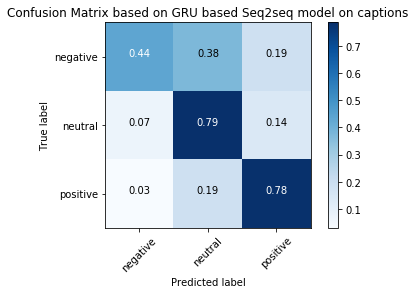

three men two women dressed medieval costumes sit benches wooden table. table horn, furred hat, apple it. shield nearby. TL 1 PL 0
three boys playing refugee camp tents behind them. TL 0 PL 1
group male workers, mostly children factory. TL 0 PL 1
leafless tree, covered snow. ground tree also covered snow, tracks seen right tree. TL 1 PL 0
three girls ring holding hands. outdoors. brown skin straight black hair. TL 1 PL 0
black white photo woman sitting ground one hand face top head. TL -1 PL 1
dog leash mouth open, looking alertly towards camera. TL 1 PL -1
white dog running across grass ears flying. TL 1 PL 0
brown dog paws nose fence looking it. TL -1 PL 0
pasta salad olives tomatoes TL 0 PL -1
several containers raspberries. TL 1 PL 0
dirty damaged photograph woman messy hair holding head hands. TL -1 PL 1
man holding head hands. TL -1 PL 0
man walks amidst crosses marking graves cemetery. TL -1 PL 0
sunset small cemetery. TL 0 PL 1
bald man head wooden table. grasps empty liquor bo

In [39]:
def evalaute_on_test_data(model, testDataset, inputDataset, wordToVec, config):
    print("filenames: ", testDataset['image_name'].values)
    max_seq_len = int(testDataset['caption'].map(lambda x: caput.get_non_stop_word_count(x.split())).max())
    print("max_seq_len", max_seq_len)
    #num_of_classes, class_to_index, index_to_class = caput.get_label_map_from_train_set(inputDataset, wordToVec, max_seq_len, config)
    class_to_index = {}
    index_to_class = {}
    _, _, num_of_classes, class_to_index, index_to_class,_ = caput.load_dataset_StratifiedKFold(
                                                                inputDataset,
                                                                wordToVec, 
                                                                max_seq_len, 
                                                                class_to_index, 
                                                                index_to_class,
                                                                config)
    
    X_test, y_test_index, _, _, _,filenames  = caput.load_dataset_StratifiedKFold(testDataset,wordToVec,max_seq_len,class_to_index, index_to_class, config)
    y_test = caput.convert_index_to_one_hot(y_test_index, num_of_classes) 
    print(model.summary())
    
    print("class_to_index", class_to_index)
    print("index_to_class", index_to_class)
    
    results = model.evaluate(X_test, y_test, verbose=1) # batch_size=1,
    print(model.metrics_names, results)
    predictions = []
    imgToPrediction = {}
    for x_test, image_name in zip(X_test, filenames):
        prediction = model.predict(np.array([x_test]),batch_size=1, verbose=0)[0]    
        #print(image_name,prediction)
        predictions.append(prediction)
        imgToPrediction[image_name] = prediction
        
    predictions = np.array(predictions)
    #predictions = model.predict(X_test, verbose=1)    
    #print("predictions:\n",predictions)
    print("\n")
    print("class_to_index:", class_to_index)
    print("index_to_class:", index_to_class)
    predictionClasses = imut.conver_predictions_to_classes(predictions, class_to_index)
    y_test_classes = [index_to_class[k] for k in y_test_index]
    y_true = y_test_classes
    print("y_true:\n", y_true)
    print("\n")
    y_pred = predictionClasses
    print("y_pred:\n", y_pred)
    
    
    cnf_matrix = confusion_matrix(y_true, y_pred)
    print("cnf_matrix", cnf_matrix)
    titleOfConfusionMatrix = "Confusion Matrix based on GRU based Seq2seq model on captions"
    pt.plot_confusion_matrix_from_labels(y_true, y_pred, titleOfConfusionMatrix)
    misLabeledCount = 0
    for index, row in testDataset.iterrows():
        caption = row['caption']
        label = row['label']
        if label != y_true[index]:
            print(caption)
            raise "Unexpected result, truth labels should have matched, seems the order is messed up"
        if label != y_pred[index]:
            print(caption,"TL", label,"PL", y_pred[index])
            misLabeledCount += 1 
    print("\n")
    print("Mislabeled count: ", misLabeledCount)
    print("\n")
    print("imgToPrediction=",imgToPrediction)
    
evalaute_on_test_data(model, testDataset, inputDataset, wordToVec, get_config())    

In [24]:
testDataset.head()

,index,id,caption,label,image_name
0,1,I10,bar several bottles wine partially-filled wine...,0,Alcohol 7.jpg
1,5,I103,"smiling woman wearing orange top blue shorts, ...",1,Bungee jumping 3.jpg
2,8,I106,three men two women dressed medieval costumes ...,1,Camping 3.jpg
3,13,I110,three boys playing refugee camp tents behind t...,0,Camping 8.jpg
4,14,I111,person wearing hat coat sunburned faced lookin...,0,Camping 9.jpg
